In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import numpy as np
from astropy.time import Time
import datetime
from collections import defaultdict
from scipy.spatial import cKDTree

In [38]:
df_coh = pd.read_pickle('/datax/scratch/ellambishop/test_refine/non_vlass_other.pkl')
df_incoh = pd.read_pickle('/datax/scratch/ellambishop/test_refine/non_vlass_incoherent.pkl')

columns = ['file_uri', 'observation_id','source_name', 'beam_id', 'ra_hours', 'dec_degrees', 'tstart',
               'signal_frequency', 'signal_beam', 'signal_drift_rate', 'signal_snr',
               'signal_power', 'signal_incoherent_power', 'signal_num_timesteps']
              # 'incoh_power', 'incoh_snr', 'freq_has_incoherent_counterpart', 'freq_has_phase_center_counterpart' ]
coh_df= df_coh[columns]
incoh_df = df_incoh[columns]

print(len(coh_df), len(incoh_df))

804791 232695


In [39]:
#pairing coherent and incoherent hits to compute power ratios properly 
coh_df = coh_df.reset_index(drop=True)
incoh_df = incoh_df.reset_index(drop=True)

coh_freqs = coh_df["signal_frequency"].values.reshape(-1, 1)
incoh_freqs = incoh_df["signal_frequency"].values.reshape(-1, 1)

tree = cKDTree(coh_freqs)
freq_tolerance = 1e-6

dists, idxs = tree.query(incoh_freqs, distance_upper_bound=freq_tolerance)

matched_mask = idxs != len(coh_freqs)
matched_incoh = incoh_df.iloc[np.where(matched_mask)[0]]
matched_idxs = idxs[matched_mask]

matched_pairs = []

for incoh_idx, coh_idx in zip(matched_incoh.index, matched_idxs):
    incoh_row = incoh_df.loc[incoh_idx]
    coh_row = coh_df.iloc[coh_idx]

    pair = {
        'observation_id': coh_row['observation_id'], 
        "ra_hours": coh_row['ra_hours'],
        "dec_degrees": coh_row['dec_degrees'], 
        "file_uri": coh_row["file_uri"],
        "incoh_file": incoh_row["file_uri"],
        "signal_frequency": coh_row["signal_frequency"],
        "signal_beam": coh_row['signal_beam'],
        "signal_power": coh_row["signal_power"],
        "incoh_power": incoh_row["signal_power"],
        "power_ratio": coh_row["signal_power"] / incoh_row["signal_power"] if incoh_row["signal_power"] > 0 else np.nan,
        "tstart": coh_row["tstart"],
        "tstart_incoh": incoh_row["tstart"],
        "beam_id": coh_row["beam_id"],
        "beam_incoh": incoh_row["beam_id"],
        'signal_snr': coh_row['signal_snr'],
        'snr_incoh': incoh_row['signal_snr'],
        'signal_drift_rate': coh_row['signal_drift_rate'], 
        'drift_incoh': incoh_row['signal_drift_rate'] 

    }

    matched_pairs.append(pair)


unmatched_incoh = incoh_df.iloc[np.where(~matched_mask)[0]]

matched_coh_indices = set(matched_idxs)
all_coh_indices = set(range(len(coh_df)))
unmatched_coh_indices = list(all_coh_indices - matched_coh_indices)

unmatched_coh = coh_df.iloc[unmatched_coh_indices]

matched_df = pd.DataFrame(matched_pairs)
matched_df['signal_frequency'] = round(matched_df['signal_frequency'],3)

# Coherent hits
num_coh_total = len(coh_df)
num_coh_matched = len(set(matched_idxs))  # unique coherent hits matched
num_coh_unmatched = len(unmatched_coh)

print(f"Coherent hits total: {num_coh_total}")
print(f"Matched coherent hits: {num_coh_matched}")
print(f"Unmatched coherent hits: {num_coh_unmatched}")
print("Match check:", num_coh_total == (num_coh_matched + num_coh_unmatched))

# Incoherent hits
num_incoh_total = len(incoh_df)
num_incoh_matched = len(matched_incoh)
num_incoh_unmatched = len(unmatched_incoh)


print(f"\nIncoherent hits total: {num_incoh_total}")
print(f"Matched incoherent hits: {num_incoh_matched}")
print(f"Unmatched incoherent hits: {num_incoh_unmatched}")
print("Match check:", num_incoh_total == (num_incoh_matched + num_incoh_unmatched))



Coherent hits total: 804791
Matched coherent hits: 51904
Unmatched coherent hits: 752887
Match check: True

Incoherent hits total: 232695
Matched incoherent hits: 65117
Unmatched incoherent hits: 167578
Match check: True


/tmp/ipykernel_1922168/1987373234.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10000)  # zoom y-axis between ymin and ymax


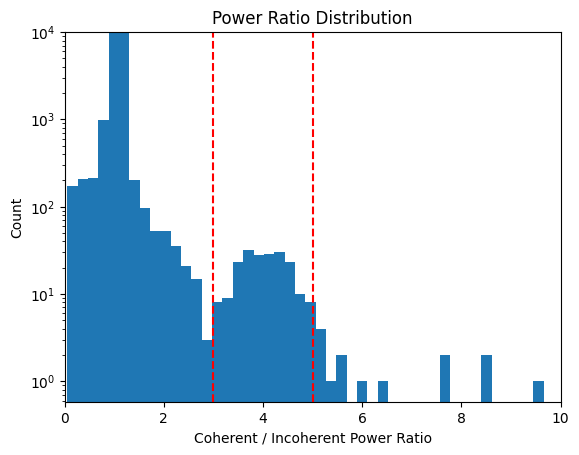

In [40]:
#compute power ratio with paired incoherent values

plt.hist(matched_df['power_ratio'], bins=50)
plt.yscale('log')
plt.axvline(3, color='r', linestyle='--')
plt.axvline(5, color='r', linestyle='--')
plt.xlim(0, 10)  # zoom x-axis between xmin and xmax
plt.ylim(0, 10000)  # zoom y-axis between ymin and ymax
plt.xlabel('Coherent / Incoherent Power Ratio')
plt.ylabel('Count')
plt.title('Power Ratio Distribution')
plt.show()


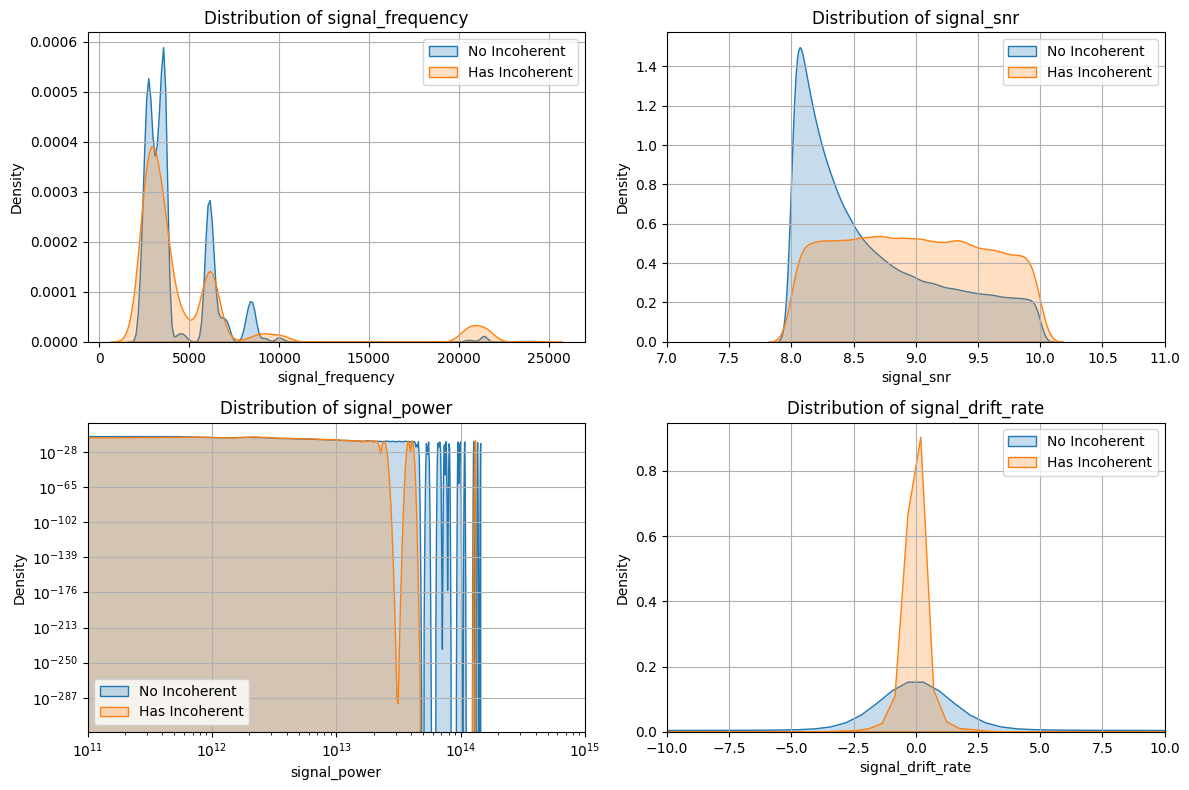

In [41]:
no_incoh_df = unmatched_coh
has_incoh_df = matched_df

features = ['signal_frequency', 'signal_snr', 'signal_power', 'signal_drift_rate']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    # Plot KDEs on each subplot
    sns.kdeplot(no_incoh_df[col].dropna(), label='No Incoherent', fill=True, ax=axes[i])
    sns.kdeplot(has_incoh_df[col].dropna(), label='Has Incoherent', fill=True, ax=axes[i])
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True)
    
    # Optional zooming and scaling
    if col == 'signal_snr':
        axes[i].set_xlim(7, 11)
    elif col == 'signal_power':
        axes[i].set_xscale('log')
        axes[i].set_xlim(1e11, 1e15)
        axes[i].set_yscale('log')
    elif col == 'signal_drift_rate':
        axes[i].set_xlim(-10, 10)

plt.tight_layout()
plt.show()

In [42]:
full_df = matched_df

In [43]:
#convert time to dates and flag the different NRAO configurations and add config, date, and antenna columns

# Extended VLA configuration date ranges to fill gaps
vla_config_ranges = [
    (datetime.date(2023, 1, 19), datetime.date(2023, 5, 29), 'B'),
    (datetime.date(2023, 6, 2),  datetime.date(2023, 6, 19), 'BnA'),
    (datetime.date(2023, 6, 30), datetime.date(2023, 10, 2), 'A'),
    (datetime.date(2023, 10, 3), datetime.date(2023, 10, 19), 'A'),
    (datetime.date(2023, 10, 20), datetime.date(2024, 1, 15), 'D'),
    (datetime.date(2024, 1, 16), datetime.date(2024, 1, 24), 'D'),   # patch
    (datetime.date(2024, 1, 25), datetime.date(2024, 5, 7), 'C'),
    (datetime.date(2024, 5, 8),  datetime.date(2024, 9, 16), 'B'),
    (datetime.date(2024, 9, 17), datetime.date(2024, 10, 7), 'BnA'),
    (datetime.date(2024, 10, 8), datetime.date(2025, 2, 3), 'A'),
    (datetime.date(2025, 2, 4), datetime.date(2025, 2, 24), 'A'),     # new patch
    (datetime.date(2025, 2, 25), datetime.date(2025, 5, 12), 'D'),
    (datetime.date(2025, 5, 13), datetime.date(2025, 5, 21), 'C'),    # patch
    (datetime.date(2025, 5, 22), datetime.date(2025, 8, 18), 'C'),
    (datetime.date(2025, 8, 19), datetime.date(2025, 9, 2), 'B'),     # patch
    (datetime.date(2025, 9, 3),  datetime.date(2026, 1, 20), 'B'),
]

# Config → number of antennas (nominal value = 27)
config_to_n_antennas = {
    'A': 27,
    'B': 27,
    'C': 27,
    'D': 27,
    'BnA': 27,
    'CnB': 27,
    'Unknown': np.nan  # fallback for unmatched configs
}

# Parse times, configs, and assign number of antennas
dates = []
configs = []
n_antennas_list = []

for t in full_df['tstart']:
    try:
        time = Time(t, format='mjd')
        date_str = time.to_value('iso', subfmt='date')
        date_obj = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        dates.append(date_str)

        matched_config = 'Unknown'
        for start, end, config in vla_config_ranges:
            if start <= date_obj <= end:
                matched_config = config
                break
        configs.append(matched_config)
        n_antennas_list.append(config_to_n_antennas.get(matched_config, np.nan))

    except Exception as e:
        print(f"[!] Error parsing tstart={t}: {e}")
        dates.append('Invalid')
        configs.append('Unknown')
        n_antennas_list.append(np.nan)

# Update the dataframe
full_df['date'] = dates
full_df['config'] = configs
full_df['n_antennas'] = n_antennas_list

# Optional preview
print(full_df['config'].value_counts())
print(full_df[['config', 'n_antennas']].drop_duplicates())


config
D      28954
A      24958
B       8740
C       2367
BnA       98
Name: count, dtype: int64
     config  n_antennas
0         D          27
17        B          27
28        A          27
437       C          27
9684    BnA          27


In [44]:
# calculate and assign the size of the beam for each hit 
def assign_beam_size_arcsec(full_df):
    # Define band frequency ranges (MHz)
    band_ranges_mhz = {
        'S':  (2000, 4000),   # 3.0 GHz
        'C':  (4000, 8000),   # 6.0 GHz
        'X':  (8000, 12000),  # 10 GHz
        'Ku': ()
    }

    # Beam size per band and configuration (arcsec)
    beam_resolutions = {
        'S':  {'D': 23,   'C': 7.0,  'B': 2.1,  'A': 0.65},
        'C':  {'D': 12,   'C': 3.5,  'B': 1.0,  'A': 0.33},
        'X':  {'D': 7.2,  'C': 2.1,  'B': 0.6,  'A': 0.20},
    }

    # Build band assignment conditions
    conditions = [
        (full_df['signal_frequency'] >= 2000) & (full_df['signal_frequency'] < 4000),
        (full_df['signal_frequency'] >= 4000) & (full_df['signal_frequency'] < 8000),
        (full_df['signal_frequency'] >= 8000) & (full_df['signal_frequency'] < 12000),
    ]
    band_labels = ['S', 'C', 'X']

    # Assign bands
    full_df['band'] = np.select(conditions, band_labels, default=None)

    # Create lookup dictionary
    beam_lookup = {
        (band, cfg): size
        for band, cfgs in beam_resolutions.items()
        for cfg, size in cfgs.items()
    }

    # Combine band and config as key
    full_df['beam_key'] = list(zip(full_df['band'], full_df['config']))

    # Assign beam size
    full_df['beam_size_arcsec'] = full_df['beam_key'].map(beam_lookup)

    return full_df
full_df= assign_beam_size_arcsec(full_df)

In [45]:
#split up the df by number of beams hit is found in, making sure to remove anything detected in 6 or
def split_hits_by_beam(df):
    import pandas as pd
    from collections import defaultdict

    grouped_dfs = defaultdict(list)

    for (tstart, fov), group in df.groupby(['tstart', 'file_uri']):
        group = group.copy()
        
        beam_counts = group.groupby('signal_frequency')['signal_beam'].nunique()

        for freq, n_beams in beam_counts.items():
            if n_beams > 5:
                continue
            hit_group = group[group['signal_frequency'] == freq]
            key = f'{n_beams}_beams'

            # DEBUG: Log frequencies and beam counts
            #print(f"[DEBUG] FOV '{fov}': freq={freq} found in {n_beams} beams, assigning to '{key}'")

            grouped_dfs[key].append(hit_group)

    # Combine all groups into DataFrames
    for key in grouped_dfs:
        grouped_dfs[key] = pd.concat(grouped_dfs[key], ignore_index=True)
        print(f"[RESULT] {key} → {len(grouped_dfs[key])} hits")

    return grouped_dfs


In [46]:
# split and create separate df for hits detection in 2 or less beams or 3 or more beams, 

# Split hits by beam count
df_groups = split_hits_by_beam(full_df)

# --- Safe helper to get beam group as list of DataFrames ---
def get_beam_group(group_key):
    group = df_groups.get(group_key, [])
    if isinstance(group, pd.DataFrame):
        return [group]
    elif isinstance(group, list):
        return group
    else:
        return []

# Combine 1- and 2-beam hits
beams_1 = get_beam_group('1_beams')
beams_2 = get_beam_group('2_beams')
combined_1_2 = beams_1 + beams_2

if combined_1_2:
    df_1_2_beam = pd.concat(combined_1_2, ignore_index=True)
else:
    df_1_2_beam = pd.DataFrame()
    print("No hits found in 1- or 2-beam groups.")

# Combine 3-, 4-, and 5-beam hits
beams_3 = get_beam_group('3_beams')
beams_4 = get_beam_group('4_beams')
beams_5 = get_beam_group('5_beams')
combined_3_4 = beams_3 + beams_4 + beams_5

if combined_3_4:
    df_3_4_5_beam = pd.concat(combined_3_4, ignore_index=True)
else:
    df_3_4_5_beam = pd.DataFrame()
    print("No hits found in 3-, 4-, or 5-beam groups.")


[RESULT] 1_beams → 63600 hits
[RESULT] 2_beams → 1494 hits
[RESULT] 3_beams → 23 hits


In [47]:
#flag overlapping signals in spacially separated beams as rfi, same file uri/fov 
def flag_local_rfi(df, area_multiplier=3, beam_threshold_fraction=0.75):
    from scipy.spatial import ConvexHull
    import numpy as np

    local_flag_count = 0
    df['rfi_flag_local'] = False

    unique_freqs = sorted(df['signal_frequency'].unique())

    # ⚡ Precompute beam counts per FOV
    beam_count_by_fov = df.groupby('file_uri')['signal_beam'].nunique().to_dict()

    for freq in unique_freqs:
        freq_subset = df[df['signal_frequency'] == freq]

        for fov in freq_subset['file_uri'].unique():
            subset = freq_subset[freq_subset['file_uri'] == fov]
            unique_beams = subset['signal_beam'].unique()

            total_beams = beam_count_by_fov.get(fov, 0)
            min_required_beams = max(3, int(beam_threshold_fraction * total_beams))

            if len(unique_beams) < min_required_beams or len(subset) < 3:
                continue

            ra0, dec0 = np.mean(subset['ra_hours']), np.mean(subset['dec_degrees'])
            ra_offsets = (subset['ra_hours'] - ra0) * 3600 * np.cos(np.deg2rad(dec0))
            dec_offsets = (subset['dec_degrees'] - dec0) * 3600
            points = np.vstack([ra_offsets, dec_offsets]).T

            try:
                hull = ConvexHull(points)
                hit_area = hull.area
            except:
                hit_area = 0

            avg_beam_size = subset['beam_size_arcsec'].mean()
            beam_area = np.pi * (avg_beam_size / 2)**2
            threshold_area = area_multiplier * beam_area

            if hit_area > threshold_area:
                df.loc[subset.index, 'rfi_flag_local'] = True
                local_flag_count += len(subset)

    return df, local_flag_count


if 'df_3_4_5_beam' in locals() and isinstance(df_3_4_5_beam, pd.DataFrame) and not df_3_4_5_beam.empty:
    df_3_4_5_beam['rfi_flag_local'] = False
    df_3_4_5_beam, local_count = flag_local_rfi(df_3_4_5_beam)
else:
    print("df_3_4_5_beam is missing or empty; skipping local RFI flagging.")
    local_count = 0

In [48]:
#flagging frequencies and drift rates found in same place at dif times/ time persistent rfi 
def flag_temporal_persistence_rfi(df,
                                   frequency_tol=1.0,
                                   drift_tol=1.0,
                                   radius_multiplier=3,
                                   min_time_gap=10,  # seconds
                                   min_repeat_count=2,
                                   debug=False):
    """
    Flags signals as RFI if they appear at the same sky location (within 3x beam size),
    same freq/drift (within tolerance), at different times (≥ min_time_gap),
    and occur at least min_repeat_count times.
    """
    df = df.copy()
    df['rfi_flag_global'] = False

    df['freq_bin'] = (df['signal_frequency'] / frequency_tol).round().astype(int)
    df['drift_bin'] = (df['signal_drift_rate'] / drift_tol).round().astype(int)

    dec_mean = df['dec_degrees'].mean()
    df['ra_arcsec'] = df['ra_hours'] * 3600 * np.cos(np.deg2rad(dec_mean))
    df['dec_arcsec'] = df['dec_degrees'] * 3600

    flagged_indices = set()
    grouped = df.groupby(['freq_bin', 'drift_bin'])

    for (f_bin, d_bin), group in grouped:
        if len(group) < min_repeat_count:
            continue

        coords = group[['ra_arcsec', 'dec_arcsec']].values
        beam_sizes = group['beam_size_arcsec'].values
        times = group['tstart_datetime'].values
        tree = cKDTree(coords)

        for i in range(len(group)):
            r_i = radius_multiplier * beam_sizes[i]
            time_i = times[i]

            idx_neighbors = tree.query_ball_point(coords[i], r=r_i)
            repeat_times = []

            for j in idx_neighbors:
                if i == j:
                    continue
                time_j = times[j]
                time_diff = abs(pd.Timedelta(time_i - time_j).total_seconds())
                if time_diff >= min_time_gap:
                    repeat_times.append(group.index[j])

            if len(set(repeat_times)) >= (min_repeat_count - 1):
                flagged_indices.add(group.index[i])
                flagged_indices.update(repeat_times)

    df.loc[list(flagged_indices), 'rfi_flag_global'] = True
    return df, len(flagged_indices)
if 'df_3_4_5_beam' in locals() and isinstance(df_3_4_5_beam, pd.DataFrame) and not df_3_4_5_beam.empty:
    df_3_4_5_beam['tstart_datetime'] = Time(df_3_4_5_beam['tstart'], format='mjd').to_datetime()
    df_3_4_5_beam['rfi_flag_global'] = False
    df_3_4_5_beam, global_count = flag_temporal_persistence_rfi(df_3_4_5_beam)
    print(f"Global RFI flagged: {global_count}")
else:
    print("df_3_4_5_beam is missing or empty; skipping local RFI flagging.")
    global_count = 0



Global RFI flagged: 0


In [49]:
if 'df_3_4_5_beam' in locals() and isinstance(df_3_4_5_beam, pd.DataFrame) and not df_3_4_5_beam.empty:
# Group by freq/drift and count unique FOVs (file_uri) broader global rfi search 
    repeat_groups = df_3_4_5_beam.groupby(['signal_frequency', 'signal_drift_rate'])['tstart'].nunique()

    # Find freq/drift pairs appearing in more than one distinct FOV
    suspect_freqs = repeat_groups[repeat_groups > 1].index

    # Mark those rows in the dataframe
    df_3_4_5_beam['global_freq_repeat'] = df_3_4_5_beam.set_index(['signal_frequency', 'signal_drift_rate']).index.isin(suspect_freqs)

    df_3_4_5_beam['flag_strength']= 0
    # Increase flag_strength for these broad repeats
    df_3_4_5_beam.loc[df_3_4_5_beam['global_freq_repeat'], 'flag_strength'] += 2

    print(f"Temporal persistence global RFI flagged: {(df_3_4_5_beam['rfi_flag_global']).sum()}")
    print(f"Multi-FOV freq+drift repeats flagged: {df_3_4_5_beam['global_freq_repeat'].sum()}")

Temporal persistence global RFI flagged: 0
Multi-FOV freq+drift repeats flagged: 0


In [50]:
#set all flags within the df 
def apply_rfi_flagging(df, local_count=None, global_count=None,
                       apply_spatial_flags=True,
                       apply_power_ratio_flag=True,
                       power_ratio_threshold=1.0,
                       debug=False):
    if local_count is not None:
        print(f"Local RFI flagged:  {local_count}")
    if global_count is not None:
        print(f"Global RFI flagged: {global_count}")


    # Conditions
    #cond1 = (df['rfi_flag_local']) & (~df['freq_has_incoherent_counterpart']) if apply_spatial_flags else pd.Series(False, index=df.index)

    cond2 = df['power_ratio'].notna() & ((df['power_ratio'] < 3) | (df['power_ratio'] > 5))
    
    #cond3 = df['freq_has_phase_center_counterpart']
    global_only = (df['rfi_flag_global']) & (~df['rfi_flag_local']) if apply_spatial_flags else pd.Series(False, index=df.index)
    df["rfi_flag_missing_power_ratio"] = df["power_ratio"].isna()

    stage_counts = {}
    total_hits = len(df)
    df['rfi_flag'] = False
    df['flag_strength'] = 0

    stage_counts['initial'] = total_hits

    if apply_spatial_flags:
        df.loc[df['rfi_flag_local'], 'rfi_flag'] = True
        df.loc[df['rfi_flag_local'], 'flag_strength'] += 1
        stage_counts['after_local_flag'] = (~df['rfi_flag']).sum()

        df.loc[global_only, 'rfi_flag'] = True
        df.loc[global_only, 'flag_strength'] += 1
        stage_counts['after_global_only_flag'] = (~df['rfi_flag']).sum()

    #df.loc[cond1, 'rfi_flag'] = True
    #df.loc[cond1, 'flag_strength'] += 2
    #stage_counts['after_cond1'] = (~df['rfi_flag']).sum()

    df.loc[cond2, 'rfi_flag'] = True
    df.loc[cond2, 'flag_strength'] += 1
    stage_counts['after_cond2'] = (~df['rfi_flag']).sum()


    df.loc[df['global_freq_repeat'], 'rfi_flag'] = True
    df.loc[df['global_freq_repeat'], 'flag_strength'] += 2
    stage_counts['after_global_repeat'] = (~df['rfi_flag']).sum()

    #df.loc[cond3, 'flag_strength'] += 1
    df.loc[df["rfi_flag_missing_power_ratio"], "rfi_flag"] = True
    df.loc[df["rfi_flag_missing_power_ratio"], "flag_strength"] += 1
    stage_counts['after_missing_power_ratio'] = (~df['rfi_flag']).sum()


    if debug:
        print("Counts for conditions:")
        #print(f"cond1 (local + no incoherent): {cond1.sum()}")
        print(f"cond2 (power 3-5)): {cond2.sum()}")
        print(f"global_only (global but not local): {global_only.sum()}")
        print(f"global_freq_repeat: {df['global_freq_repeat'].sum()}")
        #print(f"cond3 (phase center): {cond3.sum()}")
        print("Total hits with power_ratio:", df['power_ratio'].notna().sum())
        print("Hits with power_ratio outside [3,5]:", ((df['power_ratio'] < 3) | (df['power_ratio'] > 5)).sum())


        # EXTRA: For cases with apply_spatial_flags=False, print cond1 and cond2 counts separately
        if not apply_spatial_flags:
            #print(f"cond1 total (should be zero): {cond1.sum()}")  # likely zero here
            print(f"cond2 total: {cond2.sum()}")

    return df, stage_counts



In [51]:
#split the pickle file into rfi levels for future analysis 
def split_by_flag_strength(df, clean_thresh=0, maybe_thresh=1):
 
    clean_df = df[df['flag_strength'] <= clean_thresh]
    maybe_rfi_df = df[(df['flag_strength'] > clean_thresh) & (df['flag_strength'] <= maybe_thresh)]
    strong_rfi_df = df[df['flag_strength'] > maybe_thresh]
    return clean_df, maybe_rfi_df, strong_rfi_df

if 'df_3_4_5_beam' in locals() and isinstance(df_3_4_5_beam, pd.DataFrame) and not df_3_4_5_beam.empty:
    df_multi_beam, stage_counts_3_4_5 = apply_rfi_flagging(
        df_3_4_5_beam,
        local_count=local_count,
        global_count=global_count,
        apply_spatial_flags=True,
        power_ratio_threshold=1,
        debug=True,
        # <<< This is necessary to get hit_counts and stages
    )

for col in ['rfi_flag_local', 'rfi_flag_global', 'global_freq_repeat', 'freq_has_incoherent_counterpart', 'freq_has_phase_center_counterpart']:
    if col not in df_1_2_beam.columns:
        df_1_2_beam[col] = False

df_single_beam, stage_count_1_2 = apply_rfi_flagging(
    df_1_2_beam,
    apply_spatial_flags=False,
    power_ratio_threshold=1,
    debug=True,
    # <<< Needed here too
)
# Combine datasets
fin_df = pd.concat([df_single_beam, df_multi_beam], ignore_index=True)

# Split based on flag strength
clean_df, maybe_rfi_df, strong_rfi_df = split_by_flag_strength(fin_df)

# Print summary counts
print(f"Total detections: {len(df_coh)}")
print(f"Likely clean (flag_strength ≤ 0): {len(clean_df)}")
print(f"Maybe RFI (flag_strength == 1):   {len(maybe_rfi_df)}")
print(f"Strong RFI (flag_strength > 1):   {len(strong_rfi_df)}")
print(f'percentage cleaned: {(float(len(clean_df)/float(len(df_coh))))*100}')


Local RFI flagged:  17
Global RFI flagged: 0
Counts for conditions:
cond2 (power 3-5)): 23
global_only (global but not local): 0
global_freq_repeat: 0
Total hits with power_ratio: 23
Hits with power_ratio outside [3,5]: 23
Counts for conditions:
cond2 (power 3-5)): 64896
global_only (global but not local): 0
global_freq_repeat: 0
Total hits with power_ratio: 65094
Hits with power_ratio outside [3,5]: 64896
cond2 total: 64896
Total detections: 804791
Likely clean (flag_strength ≤ 0): 198
Maybe RFI (flag_strength == 1):   64902
Strong RFI (flag_strength > 1):   17
percentage cleaned: 0.024602660815043906


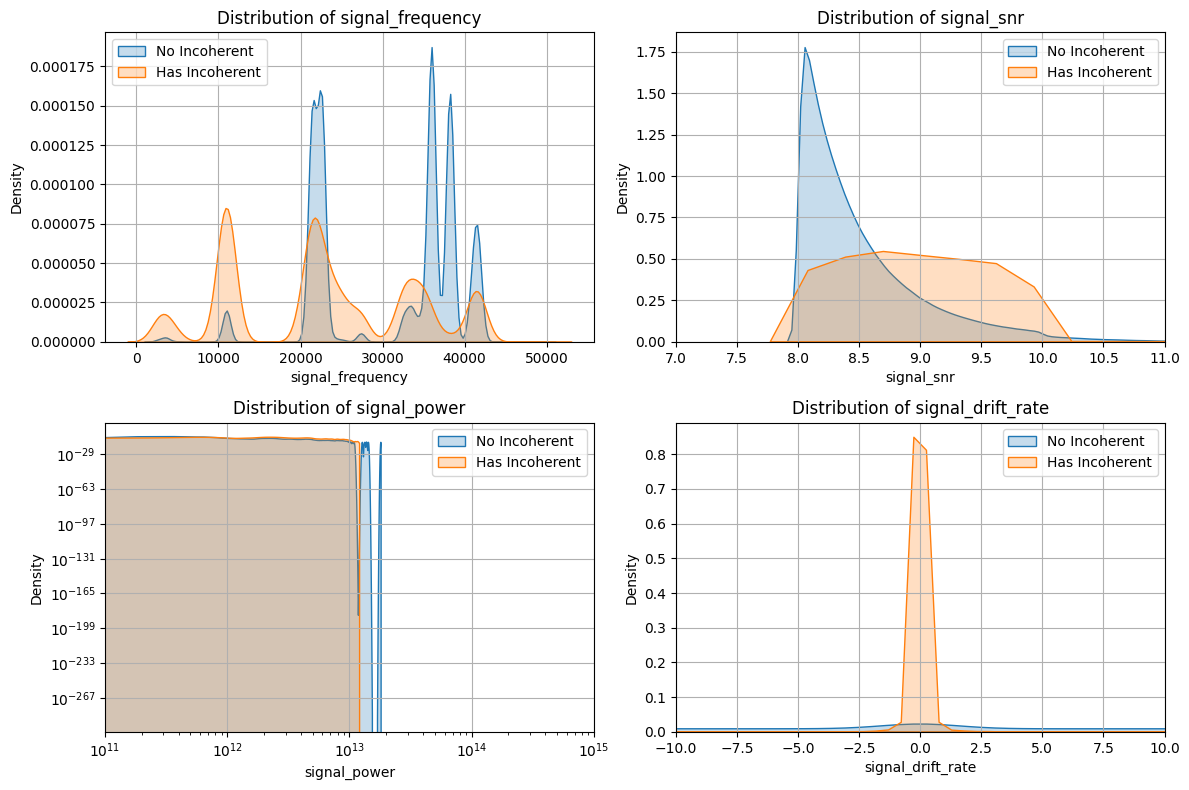

In [ ]:
no_incoh_df = unmatched_coh
has_incoh_df = matched_df

features = ['signal_frequency', 'signal_snr', 'signal_power', 'signal_drift_rate']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    # Plot KDEs on each subplot
    sns.kdeplot(no_incoh_df[col].dropna(), label='No Incoherent', fill=True, ax=axes[i])
    sns.kdeplot(has_incoh_df[col].dropna(), label='Has Incoherent', fill=True, ax=axes[i])
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True)
    
    # Optional zooming and scaling
    if col == 'signal_snr':
        axes[i].set_xlim(7, 11)
    elif col == 'signal_power':
        axes[i].set_xscale('log')
        axes[i].set_xlim(1e11, 1e15)
        axes[i].set_yscale('log')
    elif col == 'signal_drift_rate':
        axes[i].set_xlim(-10, 10)

plt.tight_layout()
plt.show()

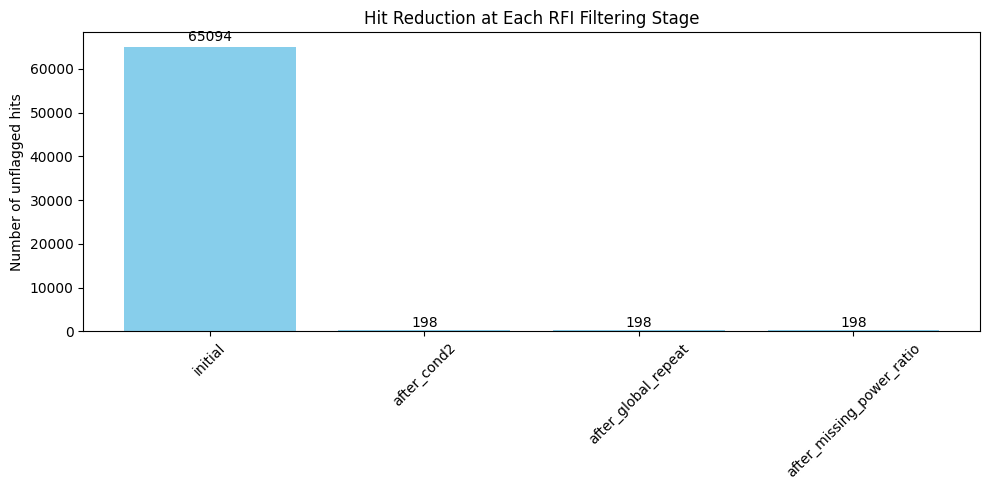

In [21]:
import matplotlib.pyplot as plt

stages = list(stage_count_1_2.keys())
counts = list(stage_count_1_2.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(stages, counts, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Number of unflagged hits")
plt.title("Hit Reduction at Each RFI Filtering Stage")

# Add text labels on top of bars
for i, count in enumerate(counts):
    plt.text(i, count * 1.01, f"{count}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


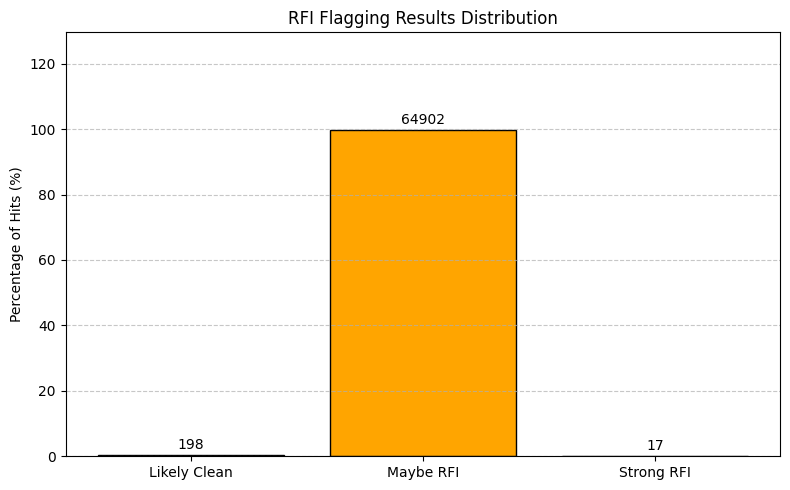

In [80]:

# Counts for each category
counts = {
    "Likely Clean": len(clean_df),
    "Maybe RFI": len(maybe_rfi_df),
    "Strong RFI": len(strong_rfi_df)
}

total = sum(counts.values())

# Calculate percentages
percentages = {k: v / total * 100 for k, v in counts.items()}

# Plot percentages bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(percentages.keys(), percentages.values(), color=['green', 'orange', 'red'], edgecolor='black')
plt.ylabel('Percentage of Hits (%)')
plt.title('RFI Flagging Results Distribution')

# Add count labels above bars
for bar, key in zip(bars, percentages.keys()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{counts[key]}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(percentages.values()) * 1.3)  # add some space above bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
clean_df.to_pickle('data/clean_df.pkl')
maybe_rfi.to_pickle('data/maybe_rfi.pkl')
strong_rfi.to_pickle('data/strong_rfi.pkl')